<a href="https://www.kaggle.com/code/munaee/straight-fwd-camvid-pytorch-deeplabv3-resnet50?scriptVersionId=185202826" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Importing Important Modules

In [1]:
# File System Handling
import os

# Data Processing
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# Image Visualization
from PIL import Image
import matplotlib.pyplot as plt

# Model Training, evaluation processes...
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models

# Handling Warnings
import warnings
warnings.filterwarnings("ignore")

# Data Pre-Processing, and Visualization

## Data pre-processing

In [2]:
# Creating sorted list of all data
ROOT_DIR = '/kaggle/input/camvid/CamVid'

train_images_path = sorted([os.path.join(ROOT_DIR, "train", image) for image in os.listdir(os.path.join(ROOT_DIR, "train"))])
train_labels_path = sorted([os.path.join(ROOT_DIR, "train_labels", image) for image in os.listdir(os.path.join(ROOT_DIR, "train_labels"))])

val_images_path = sorted([os.path.join(ROOT_DIR, "val", image) for image in os.listdir(os.path.join(ROOT_DIR, "val"))])
val_labels_path = sorted([os.path.join(ROOT_DIR, "val_labels", image) for image in os.listdir(os.path.join(ROOT_DIR, "val_labels"))])

test_images_path = sorted([os.path.join(ROOT_DIR, "test", image) for image in os.listdir(os.path.join(ROOT_DIR, "test"))])
test_labels_path = sorted([os.path.join(ROOT_DIR, "test_labels", image) for image in os.listdir(os.path.join(ROOT_DIR, "test_labels"))])

# Reading in and viewing class mappings
class_dict = pd.read_csv(os.path.join(ROOT_DIR, "class_dict.csv"))
class_dict.head()

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0


In [3]:
# Defining color-class mapping for mask generation (from label image pixels).
color_class_mapping = class_dict.set_index("name").T.to_dict("list")
color_class_mapping = {tuple(color): class_ind for class_ind, color in enumerate(color_class_mapping.values())}

# Defining class-color mapping for mask interpretation
class_color_mapping = {class_ind: color for color, class_ind in color_class_mapping.items()}

print(f"Number of classes: {len(class_dict)}\n")

print("Color pixel-class mapping")
print(color_class_mapping, "\n")

print("Pixel-class to color mapping")
print(class_color_mapping, "\n")

Number of classes: 32

Color pixel-class mapping
{(64, 128, 64): 0, (192, 0, 128): 1, (0, 128, 192): 2, (0, 128, 64): 3, (128, 0, 0): 4, (64, 0, 128): 5, (64, 0, 192): 6, (192, 128, 64): 7, (192, 192, 128): 8, (64, 64, 128): 9, (128, 0, 192): 10, (192, 0, 64): 11, (128, 128, 64): 12, (192, 0, 192): 13, (128, 64, 64): 14, (64, 192, 128): 15, (64, 64, 0): 16, (128, 64, 128): 17, (128, 128, 192): 18, (0, 0, 192): 19, (192, 128, 128): 20, (128, 128, 128): 21, (64, 128, 192): 22, (0, 0, 64): 23, (0, 64, 64): 24, (192, 64, 128): 25, (128, 128, 0): 26, (192, 128, 192): 27, (64, 0, 64): 28, (192, 192, 0): 29, (0, 0, 0): 30, (64, 192, 0): 31} 

Pixel-class to color mapping
{0: (64, 128, 64), 1: (192, 0, 128), 2: (0, 128, 192), 3: (0, 128, 64), 4: (128, 0, 0), 5: (64, 0, 128), 6: (64, 0, 192), 7: (192, 128, 64), 8: (192, 192, 128), 9: (64, 64, 128), 10: (128, 0, 192), 11: (192, 0, 64), 12: (128, 128, 64), 13: (192, 0, 192), 14: (128, 64, 64), 15: (64, 192, 128), 16: (64, 64, 0), 17: (128, 64, 12

In [4]:
# IMPORTANT FUNCTIONS AND CLASSES
def class_label_to_rgb(class_label_mask):
    """
    Converts images with labels back to RGB format.
    Accepts AxA array of pixel classes... returns RGB array.
    """
    height, width = class_label_mask.shape
    rgb_mask = np.zeros((height, width, 3), dtype=np.uint8)
    
    for class_label, color in class_color_mapping.items():
        rgb_mask[class_label_mask == class_label] = color
    
    return rgb_mask

def denormalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    for t, m, s in zip(image, mean, std):
        t.mul_(s).add_(m)
    return image

def visualize(image, class_label_mask):
    rgb_mask = class_label_to_rgb(class_label_mask.numpy())
    
    # Denormalize the image
    image = denormalize(image.clone())
    
    plt.subplots(1, 2, figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.title("Image")
    plt.imshow(image.permute(1, 2, 0).clamp(0, 1))  # Clamp values between 0 and 1
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.title("Mask")
    plt.imshow(rgb_mask)
    plt.axis("off")
    plt.tight_layout()
    plt.show()


def calculate_iou_dice(outputs, targets):
    "For calculating Intersection over Union scores."
    eps = 1e-6
    outputs = torch.argmax(outputs, dim=1)
    
    intersection = (outputs & targets).float().sum((1, 2))
    union = (outputs | targets).float().sum((1, 2))
    
    iou = (intersection + eps) / (union + eps)
    dice = (2 * intersection + eps) / (outputs.sum((1, 2)) + targets.sum((1, 2)) + eps)
    
    return iou.mean(), dice.mean()
    
class SegmentationDataset(Dataset):
    """
    Handles data augmentation, and returns appropriate data for training/testing.
    """
    def __init__(self, image_paths, label_paths, train=True, image_size=224, augment_factor=1):
        self.image_paths = image_paths
        self.label_paths = label_paths
        self.train = train
        self.image_size = image_size
        self.augment_factor = augment_factor if train else 0
        
        self.image_transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.label_transform = transforms.Compose([
            transforms.Resize((self.image_size, self.image_size), interpolation=Image.NEAREST),
            transforms.ToTensor()
        ])
        
        if self.train:
            self.augment_transform = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(degrees=30)
            ])

    def __len__(self):
        return len(self.image_paths) * (self.augment_factor + 1) if self.train else len(self.image_paths)

    def __getitem__(self, idx):
        if self.train:
            orig_idx = idx // (self.augment_factor + 1)
            aug_idx = idx % (self.augment_factor + 1)
        else:
            orig_idx = idx

        image = Image.open(self.image_paths[orig_idx]).convert('RGB')
        label = Image.open(self.label_paths[orig_idx]).convert('RGB')

        if self.train and aug_idx != 0:
            seed = torch.randint(0, 2**32, (1,)).item()
            torch.manual_seed(seed)
            image = self.augment_transform(image)
            torch.manual_seed(seed)
            label = self.augment_transform(label)

        image = self.image_transform(image)
        label = self.label_transform(label)

        # Convert label to class mask
        label = label.permute(1, 2, 0).numpy() * 255  # Convert to numpy array and scale back to 0-255
        class_label_mask = np.zeros(label.shape[:2], dtype=np.uint8)
        for color, class_label in color_class_mapping.items():
            match = np.all(np.abs(label - np.array(color)) < 5, axis=-1)  # Allow small color variations
            class_label_mask[match] = class_label

        # Convert mask to tensor
        class_label_mask = torch.tensor(class_label_mask, dtype=torch.long)

        return image, class_label_mask

Image: torch.Size([4, 3, 512, 512]), | Mask: torch.Size([4, 512, 512])
[[30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]
 ...
 [30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]
 [30 30 30 ... 30 30 30]]


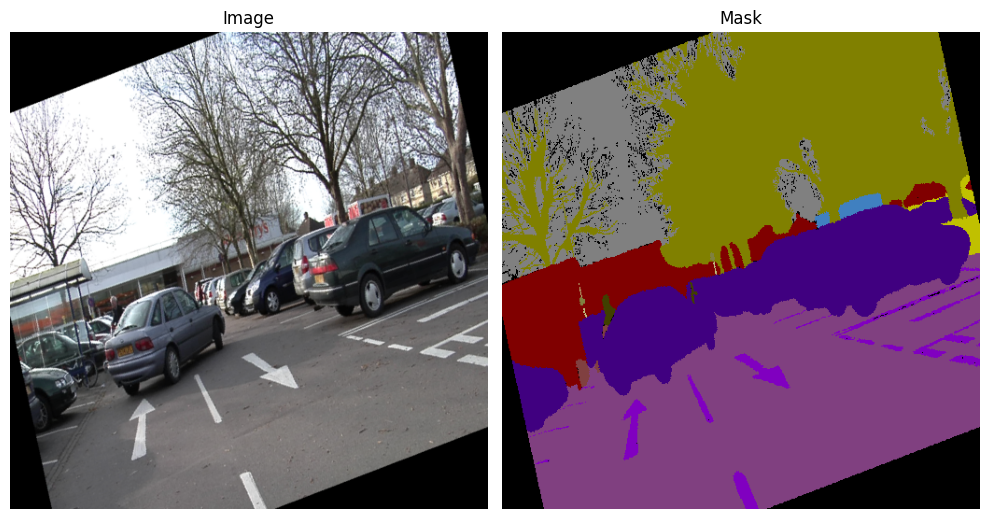

In [5]:
IMAGE_SIZE = 512
BATCH_SIZE = 4
AUGMENT_FACTOR = 2 # Number of augmented versions to add for each original image.

# data_transform = transforms.Compose([
#     transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
#     transforms.ToTensor()
# ])

train_dataset = SegmentationDataset(train_images_path, train_labels_path, train=True, image_size=IMAGE_SIZE, augment_factor=AUGMENT_FACTOR)
val_dataset = SegmentationDataset(val_images_path, val_labels_path, train=False, image_size=IMAGE_SIZE)
test_dataset = SegmentationDataset(test_images_path, test_labels_path, train=False, image_size=IMAGE_SIZE)

# Don't forget to drop last as you may encounter batch-size mismatch error towards the end of your training batch.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

# Just checking
for images, masks in train_loader:
    print(f"Image: {images.shape}, | Mask: {masks.shape}")
    print(masks[0].numpy())
    
    # Take the first image-mask pair only
    image = images[0]
    class_label_mask = masks[0]
    
    # Visualize the mask printed above by converting label back to pixels then visualizing.
    visualize(image, class_label_mask)
    break

# Model Architecture Definition, Training & evaluation

## Architecture Definition

In [6]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, num_classes):
        super(DeepLabV3Plus, self).__init__()
        self.model = models.segmentation.deeplabv3_resnet50(pretrained = True)
        self.model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1), stride=(1, 1))

    def forward(self, x):
        return self.model(x)['out']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLabV3Plus(len(class_dict)).to(device)

Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:01<00:00, 163MB/s]


## Training & evaluation

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = "torch_model_checkpoint.pth"
best_val_loss = float("inf")
# NOTE: Based on my calculations, it takes appx 8 minutes per epoch ... Adjust wisely.
num_epochs = 35 # Adjust, and experiment.

print("Training Started... WOOOOOO!!!!!")
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_iou = 0.0
    running_dice = 0.0
    
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        
        iou, dice = calculate_iou_dice(outputs, masks)
        
        running_loss += loss.item() * images.size(0)
        running_iou += iou.item() * images.size(0)
        running_dice += dice.item() * images.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_iou = running_iou / len(train_loader.dataset)
    epoch_dice = running_dice / len(train_loader.dataset)
    
    model.eval()
    val_loss = 0.0
    val_iou = 0.0
    val_dice = 0.0
    
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            iou, dice = calculate_iou_dice(outputs, masks)
            
            val_loss += loss.item() * images.size(0)
            val_iou += iou.item() * images.size(0)
            val_dice += dice.item() * images.size(0)
    
    val_loss = val_loss / len(val_loader.dataset)
    val_iou = val_iou / len(val_loader.dataset)
    val_dice = val_dice / len(val_loader.dataset)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), checkpoint_path)
        print("New Best Model Saved!")
    
    print(f"Epoch {epoch+1}/{num_epochs} ====== "
          f"Training : (Loss: {epoch_loss:.4f} - IoU: {epoch_iou:.4f} - Dice: {epoch_dice:.4f}) *=* "
          f"Validation : (Loss: {val_loss:.4f} - IoU: {val_iou:.4f} - Dice: {val_dice:.4f})")

Training Started... WOOOOOO!!!!!
New Best Model Saved!
Epoch 1/35 ====== Training : (Loss: 0.8984 - IoU: 0.7778 - Dice: 0.8717) *=* Validation : (Loss: 0.6951 - IoU: 0.8004 - Dice: 0.8874)
New Best Model Saved!
Epoch 2/35 ====== Training : (Loss: 0.6013 - IoU: 0.8237 - Dice: 0.9010) *=* Validation : (Loss: 0.6328 - IoU: 0.8224 - Dice: 0.9014)
New Best Model Saved!
Epoch 3/35 ====== Training : (Loss: 0.4913 - IoU: 0.8494 - Dice: 0.9166) *=* Validation : (Loss: 0.5077 - IoU: 0.8462 - Dice: 0.9160)
New Best Model Saved!
Epoch 4/35 ====== Training : (Loss: 0.4231 - IoU: 0.8642 - Dice: 0.9253) *=* Validation : (Loss: 0.4157 - IoU: 0.8675 - Dice: 0.9284)
Epoch 5/35 ====== Training : (Loss: 0.3701 - IoU: 0.8777 - Dice: 0.9332) *=* Validation : (Loss: 0.4178 - IoU: 0.8683 - Dice: 0.9287)
New Best Model Saved!
Epoch 6/35 ====== Training : (Loss: 0.3338 - IoU: 0.8869 - Dice: 0.9384) *=* Validation : (Loss: 0.3721 - IoU: 0.8802 - Dice: 0.9358)
Epoch 7/35 ====== Training : (Loss: 0.3290 - IoU: 0.8

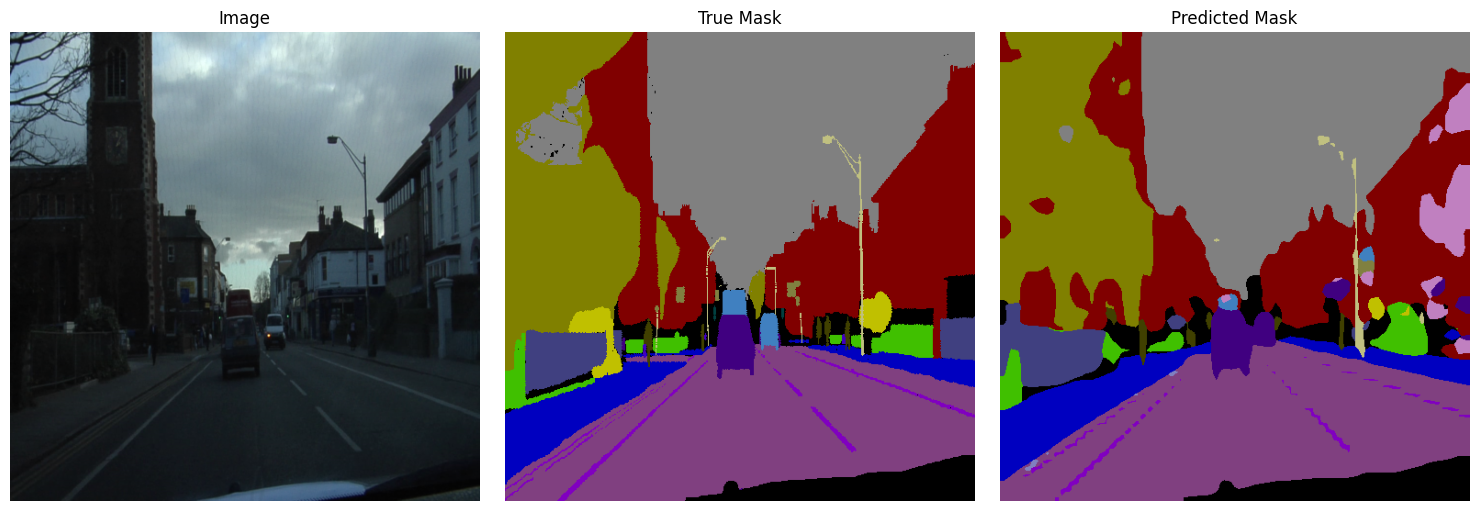

In [8]:
# THIS CELL WORKS WITH MODEL AT FINAL ITERATION, NOT NECESSARILY THE "BEST" ONE.
i = 30  # Adjust to see different images. Max = 231.

data_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_path = test_images_path[i]
true_mask_path = test_labels_path[i]

image = Image.open(image_path).convert("RGB")
true_mask = Image.open(true_mask_path).convert("RGB")

image_tensor = data_transform(image).unsqueeze(0).to(device)
true_mask = true_mask.resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)

model.eval()
with torch.no_grad():
    output = model(image_tensor)
    predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    predicted_mask = class_label_to_rgb(predicted_mask)

# Denormalize the image tensor
denormalized_image = denormalize(image_tensor.squeeze().cpu())

plt.subplots(1, 3, figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(denormalized_image.permute(1, 2, 0).clamp(0, 1))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask)
plt.axis("off")

plt.tight_layout()
plt.show()

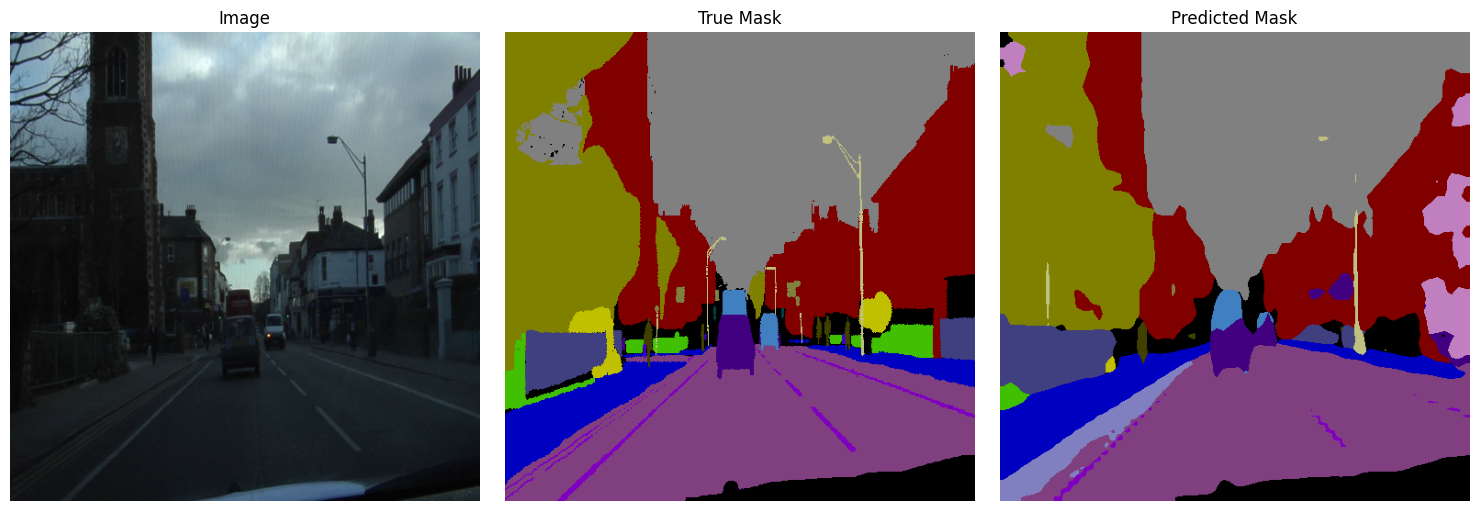

In [9]:
# This cell makes prediction with the "Best" model saved during training.

# Load the best model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DeepLabV3Plus(len(class_dict)).to(device)
model.load_state_dict(torch.load("/kaggle/working/torch_model_checkpoint.pth"))

i = 30  # Adjust to see different images. Max = 231.

data_transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_path = test_images_path[i]
true_mask_path = test_labels_path[i]

image = Image.open(image_path).convert("RGB")
true_mask = Image.open(true_mask_path).convert("RGB")

image_tensor = data_transform(image).unsqueeze(0).to(device)
true_mask = true_mask.resize((IMAGE_SIZE, IMAGE_SIZE), Image.NEAREST)

model.eval()
with torch.no_grad():
    output = model(image_tensor)
    predicted_mask = torch.argmax(output, dim=1).squeeze().cpu().numpy()
    predicted_mask = class_label_to_rgb(predicted_mask)

# Denormalize the image tensor
denormalized_image = denormalize(image_tensor.squeeze().cpu())

plt.subplots(1, 3, figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(denormalized_image.permute(1, 2, 0).clamp(0, 1))
plt.axis("off")

plt.subplot(1, 3, 2)
plt.title("True Mask")
plt.imshow(true_mask)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.title("Predicted Mask")
plt.imshow(predicted_mask)
plt.axis("off")

plt.tight_layout()
plt.show()